In [497]:
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, Flatten, Dense, Input, Reshape, LeakyReLU, BatchNormalization, UpSampling2D, Dropout, Activation
from keras.optimizers import Adam
from keras.callbacks import LambdaCallback
import numpy as np

In [472]:
from keras.preprocessing.image import ImageDataGenerator

# Autoencoder

In [473]:
BATCH_AE = 64
EPOCHS_AE = 20

In [474]:
src_path_train = "data\\train"

train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.10)

In [475]:
train_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(64, 64),
    color_mode="rgb",
    batch_size=BATCH_AE,
    subset='training',
    shuffle=True,
    seed=42,
    class_mode='input'  # делает так, чтобы и x, и y были x
)
val_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(64, 64),
    color_mode="rgb",
    batch_size=BATCH_AE,
    subset='validation',
    shuffle=False,
    seed=42,
    class_mode='input'
)

Found 22497 images belonging to 2 classes.
Found 2498 images belonging to 2 classes.


In [476]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10824707098707015124
xla_global_id: -1
]


In [477]:
a = next(iter(train_generator))

# Построение модели

In [485]:
# encoder = Sequential([
#     Input(shape=(64, 64, 3)),
#     Conv2D(32, (3, 3), activation='leaky_relu', padding='same'),
#     MaxPool2D((2, 2), padding='same'),
#     Conv2D(32, (3, 3), activation='leaky_relu', padding='same'),
#     MaxPool2D((2, 2), padding='same'),
#     Conv2D(32, (3, 3), activation='leaky_relu', padding='same'),
#     Flatten(), 
#     Dense(1536, activation='leaky_relu')
# ])

# decoder = Sequential([
#     Input(shape=(1536,)),
#     Dense(2048, activation='leaky_relu'),
#     Reshape((8, 8, 32)),
#     Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='leaky_relu', padding='same'),
#     Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='leaky_relu', padding='same'),
#     Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='leaky_relu', padding='same'),
#     Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')
# ])


# encoder = Sequential([
#     Input(shape=(64, 64, 3)),
#     Conv2D(32, (3, 3), activation='leaky_relu', padding='same'),
#     MaxPool2D((2, 2), padding='same'),
#     Conv2D(32, (3, 3), activation='leaky_relu', padding='same'),
#     MaxPool2D((2, 2), padding='same'),
#     Conv2D(32, (3, 3), activation='leaky_relu', padding='same'),
#     MaxPool2D((2, 2), padding='same'),
#     Flatten(),
#     Dense(1024, activation='leaky_relu')
# ])

# decoder = Sequential([
#     Input(shape=(1024,)),
#     Dense(2048, activation='leaky_relu'),
#     Reshape((8, 8, 32)),
#     Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='leaky_relu', padding='same'),
#     Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='leaky_relu', padding='same'),
#     Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='leaky_relu', padding='same'),
#     Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')
# ])
# autoencoder = Sequential([encoder, decoder])

# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
# autoencoder.build(input_shape=(None, 64,64,3))
# autoencoder.summary()

encoder = Sequential([
    Input(shape=(64, 64, 3)),
    Conv2D(16, (3, 3), activation='leaky_relu', padding='same'),
    MaxPool2D((2, 2), padding='same'),
    Conv2D(32, (3, 3), activation='leaky_relu', padding='same'),
    MaxPool2D((2, 2), padding='same'),
    Conv2D(64, (3, 3), activation='leaky_relu', padding='same'),
    MaxPool2D((2, 2), padding='same'),
    Flatten(),
    Dense(2048, activation='leaky_relu'),
])

decoder = Sequential([
    Input(shape=(2048,)),
    Dense(2048, activation='leaky_relu'),
    Reshape((8, 8, 32)),
    Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='leaky_relu', padding='same'),
    Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='leaky_relu', padding='same'),
    Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='leaky_relu', padding='same'),
    Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')
])
autoencoder = Sequential([encoder, decoder])

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.build(input_shape=(None, 64,64,3))
autoencoder.summary()

Model: "sequential_204"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_202 (Sequential  (None, 2048)              8414240   
 )                                                               
                                                                 
 sequential_203 (Sequential  (None, 64, 64, 3)         4224963   
 )                                                               
                                                                 
Total params: 12639203 (48.21 MB)
Trainable params: 12639203 (48.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [520]:
base_size = 4

encoder = Sequential([
    Input(shape=(64, 64, 3)),
    Conv2D(base_size, (3, 3), padding='same'),
    BatchNormalization(axis=-1),
    Activation('leaky_relu'),
    MaxPool2D((2, 2), padding='same'),
    Conv2D(2*base_size, (3, 3), padding='same'),
    BatchNormalization(axis=-1),
    Activation('leaky_relu'),
    MaxPool2D((2, 2), padding='same'),
    Conv2D(4*base_size, (3, 3), padding='same'),
    BatchNormalization(axis=-1),
    Activation('leaky_relu'),
    MaxPool2D((2, 2), padding='same'),
    Flatten(),
    Dense(2048, activation='leaky_relu'),
])

decoder = Sequential([
    Input(shape=(2048,)),
    Dense(2048, activation='leaky_relu'),
    Reshape((8, 8, 32)),
    Conv2DTranspose(4*base_size, (3, 3), strides=(2, 2), padding='same'),
    BatchNormalization(axis=-1),
    Activation('leaky_relu'),
    Conv2DTranspose(2*base_size, (3, 3), strides=(2, 2), padding='same'),
    BatchNormalization(axis=-1),
    Activation('leaky_relu'),
    Conv2DTranspose(base_size, (3, 3), strides=(2, 2), padding='same'),
    BatchNormalization(axis=-1),
    Activation('leaky_relu'),
    Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')
])
autoencoder = Sequential([encoder, decoder])

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.build(input_shape=(None, 64,64,3))
autoencoder.summary()

Model: "sequential_238"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_236 (Sequential  (None, 2048)              6312848   
 )                                                               
                                                                 
 sequential_237 (Sequential  (None, 64, 64, 3)         4229523   
 )                                                               
                                                                 
Total params: 10542371 (40.22 MB)
Trainable params: 10541987 (40.21 MB)
Non-trainable params: 384 (1.50 KB)
_________________________________________________________________


In [456]:
def basic_block(x, inp_filter, out_filter):
    x = Conv2D(inp_filter, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(out_filter, (3, 3), activation='relu', padding='same')(x)
    x = MaxPool2D((2, 2), padding='same')(x)
    return x

def basic_block_trasnpose(y, inp_filter, out_filter):
    y = Conv2DTranspose(inp_filter, (3, 3), strides=(2, 2), activation='relu', padding='same')(y)
    y = BatchNormalization(axis=-1)(y)
    y = Conv2DTranspose(out_filter, (3, 3), strides=(1, 1), activation='relu', padding='same')(y)
    return y

def build_encoder(input_shape=(64, 64, 3)):
    input_img = Input(shape=input_shape)
    x = basic_block(input_img, 16, 32)
    x = basic_block(x, 32, 64)
    x = basic_block(x, 64, 64)
    x = Conv2D(64, (1,1), padding='same')(x)
    x = Flatten()(x)
    encoded = Dense(2048, activation='relu')(x)
    encoder_model = Model(input_img, encoded, name='encoder')
    return encoder_model

def build_decoder(encoded_shape=(2048,)):
    input_encoded = Input(shape=encoded_shape)
    y = Dense(2048, activation='relu')(input_encoded)
    y = Reshape((8, 8, 32))(y)
    y = basic_block_trasnpose(y, 64, 64)
    y = basic_block_trasnpose(y, 64, 32)
    y = basic_block_trasnpose(y, 32, 16)
    decoded = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(y)    
    decoder_model = Model(input_encoded, decoded, name='decoder')
    return decoder_model

# Build encoder and decoder models
encoder = build_encoder()
decoder = build_decoder()

# Connect encoder and decoder to form the autoencoder
autoencoder_input = Input(shape=(64, 64, 3))
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = Model(autoencoder_input, decoded_img, name='autoencoder')
opt = Adam(learning_rate=1e-2)

# Compile and summarize the autoencoder
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
autoencoder.build(input_shape=(None, 64, 64, 3))
autoencoder.summary()


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_206 (InputLayer)      [(None, 64, 64, 3)]       0         
                                                                 
 encoder (Functional)        (None, 2048)              8501952   
                                                                 
 decoder (Functional)        (None, 64, 64, 3)         4322115   
                                                                 
Total params: 12824067 (48.92 MB)
Trainable params: 12823523 (48.92 MB)
Non-trainable params: 544 (2.12 KB)
_________________________________________________________________


In [453]:
#encoder(a[0]).shape
#decoder(encoded).shape
# autoencoder(image) # batch, width, heigth, channels

In [521]:
save_weights_epochs = [1, 2, 4, 8, 16]
WeightsSaver = lambda model, name, eps: LambdaCallback(
    on_epoch_end=lambda epoch, _: model.save_weights('{}_{}.h5'.format(name, epoch + 1)) \
        if epoch + 1 in eps else None)

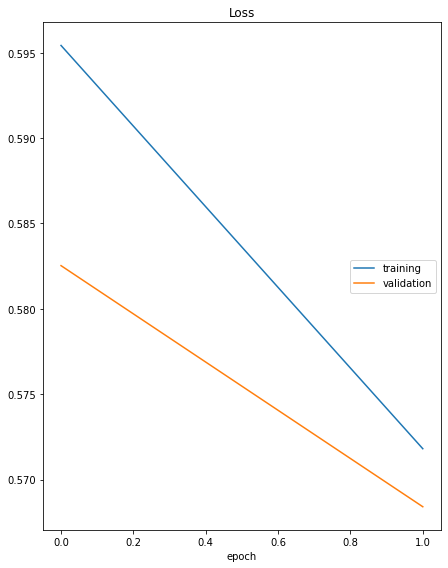

Loss
	training         	 (min:    0.572, max:    0.595, cur:    0.572)
	validation       	 (min:    0.568, max:    0.583, cur:    0.568)
352/352 [==============================] - 171s 485ms/step - loss: 0.5718 - val_loss: 0.5684
Epoch 3/20
263/352 [=====================>........] - ETA: 42s - loss: 0.5669

In [522]:
from keras.callbacks import LambdaCallback
from livelossplot import PlotLossesKeras

history = autoencoder.fit(
    train_generator,
    epochs=EPOCHS_AE,
    validation_data=val_generator,
    callbacks=[PlotLossesKeras(), WeightsSaver(
                    autoencoder, "autoencoder", save_weights_epochs)]
)

In [510]:
example = a[0][9,:,:,:]

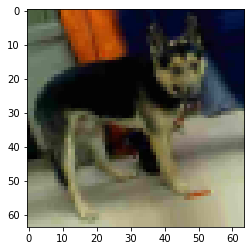

In [511]:
plt.imshow(example)

In [512]:
output = autoencoder(np.array([example]))

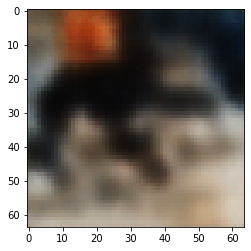

In [513]:
plt.imshow(output[0,:,:,:])

# Классификатор

Выгружаю данные для обучения классификатора(надо чтоб X и y теперь были разные)

In [492]:
train_generator_class = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(64, 64),
    color_mode="rgb",
    batch_size=BATCH_AE,
    subset='training',
    shuffle=True,
    seed=42,
    class_mode='binary' 
)
val_generator_class = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(64, 64),
    color_mode="rgb",
    batch_size=BATCH_AE,
    subset='validation',
    shuffle=False,
    seed=42,
    class_mode='binary'
)

Found 22497 images belonging to 2 classes.
Found 2498 images belonging to 2 classes.


In [493]:
a = next(iter(train_generator_class))
a

(array([[[[1.23417385e-01, 1.71400592e-01, 7.80812204e-02],
          [1.03447378e-01, 1.71737373e-01, 3.38053517e-02],
          [5.94998412e-02, 1.22808531e-01, 1.34436963e-02],
          ...,
          [4.81777966e-01, 4.69490021e-01, 4.07128274e-01],
          [4.89473104e-01, 4.57947254e-01, 3.90455395e-01],
          [4.97168303e-01, 4.77419198e-01, 3.94628465e-01]],
 
         [[1.18269399e-01, 1.63678601e-01, 8.45162123e-02],
          [1.18891351e-01, 1.76885352e-01, 5.56843095e-02],
          [7.49438107e-02, 1.51122466e-01, 7.00870901e-03],
          ...,
          [5.03815174e-01, 5.35025001e-01, 4.25646961e-01],
          [5.11510313e-01, 6.01716578e-01, 4.61557806e-01],
          [5.14010847e-01, 6.51005983e-01, 4.88637716e-01]],
 
         [[1.17047980e-01, 1.59279108e-01, 9.18573216e-02],
          [1.27770588e-01, 1.77930400e-01, 7.26397187e-02],
          [9.03877765e-02, 1.67384163e-01, 1.53042488e-02],
          ...,
          [4.98501569e-01, 6.34388924e-01, 4.8199

In [494]:
encoder.trainable = False

In [495]:
densenet = Sequential([
    encoder,
    Input(shape=(2048, 1)),
    Dense(2048, activation='relu'),
    BatchNormalization(axis=-1),
    Dense(1024, activation='relu'),
    BatchNormalization(axis=-1),
    Dense(512, activation='relu'),
    BatchNormalization(axis=-1),
    Dense(256, activation='relu'),
    BatchNormalization(axis=-1),
    Dense(1, activation='sigmoid')
])

densenet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

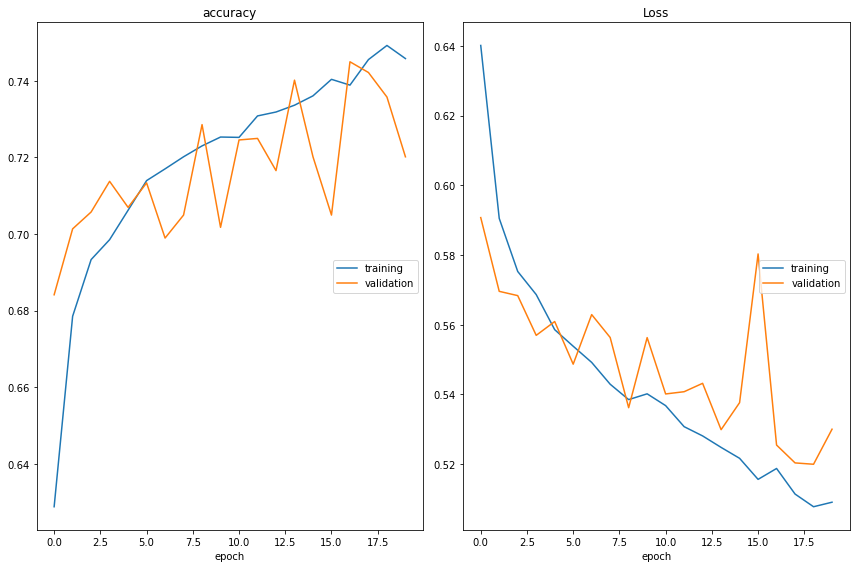

accuracy
	training         	 (min:    0.629, max:    0.749, cur:    0.746)
	validation       	 (min:    0.684, max:    0.745, cur:    0.720)
Loss
	training         	 (min:    0.508, max:    0.640, cur:    0.509)
	validation       	 (min:    0.520, max:    0.591, cur:    0.530)
352/352 [==============================] - 58s 166ms/step - loss: 0.5091 - accuracy: 0.7458 - val_loss: 0.5300 - val_accuracy: 0.7202


In [496]:
densenet.fit(train_generator_class,
              epochs=20,
              shuffle=True,
              validation_data=val_generator_class,
              callbacks=[PlotLossesKeras()])